In [6]:
import os
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import IsolationForest
import itertools
from PIL import Image
import ipaddress

In [7]:
#1.1
data = pd.read_csv('Tuesday-WorkingHours.pcap_ISCX.csv')
print("size:", data.shape)
print(data[:0])


size: (445909, 85)
Empty DataFrame
Columns: [Flow ID,  Source IP,  Source Port,  Destination IP,  Destination Port,  Protocol,  Timestamp,  Flow Duration,  Total Fwd Packets,  Total Backward Packets, Total Length of Fwd Packets,  Total Length of Bwd Packets,  Fwd Packet Length Max,  Fwd Packet Length Min,  Fwd Packet Length Mean,  Fwd Packet Length Std, Bwd Packet Length Max,  Bwd Packet Length Min,  Bwd Packet Length Mean,  Bwd Packet Length Std, Flow Bytes/s,  Flow Packets/s,  Flow IAT Mean,  Flow IAT Std,  Flow IAT Max,  Flow IAT Min, Fwd IAT Total,  Fwd IAT Mean,  Fwd IAT Std,  Fwd IAT Max,  Fwd IAT Min, Bwd IAT Total,  Bwd IAT Mean,  Bwd IAT Std,  Bwd IAT Max,  Bwd IAT Min, Fwd PSH Flags,  Bwd PSH Flags,  Fwd URG Flags,  Bwd URG Flags,  Fwd Header Length,  Bwd Header Length, Fwd Packets/s,  Bwd Packets/s,  Min Packet Length,  Max Packet Length,  Packet Length Mean,  Packet Length Std,  Packet Length Variance, FIN Flag Count,  SYN Flag Count,  RST Flag Count,  PSH Flag Count,  ACK 

In [8]:
#1.2
#1.2.1
data.drop(["Flow ID"], axis=1)

#1.2.2
data.dropna()

#1.2.3
l = {}
for col in data[:0]:
    new = col
    if col[0] == ' ':
        new = col[1:]
    l[col] = new  
data.rename(l, inplace=True, axis=1)

#1.2.4
data["Flow Beg Date"] = data.apply(lambda x: datetime.strptime(x['Timestamp'], '%m/%d/%Y %H:%M'), axis=1)
data["Flow End Date"] = data.apply(lambda x: x['Flow Beg Date'] + timedelta(milliseconds=x['Flow Duration']), axis=1)
data['Total Packets'] = data.apply(lambda x: x['Total Fwd Packets'] + x['Total Backward Packets'], axis=1)
data['Total Length of Packets'] = data.apply(lambda x: x['Total Length of Fwd Packets'] + x['Total Length of Bwd Packets'], axis=1)




In [9]:
#1.3
#1.3.1
# data.groupby([pd.Grouper(key="Flow Beg Date", freq="2min"), "Destination IP"]).aggregate({
#     'Total Packets' : 'sum',
#     'Total Length of Packets' : 'sum'}
# ).reset_index()


#1.3.2
dfagr = data.groupby(["Destination IP", pd.Grouper(key="Flow Beg Date", freq="2min")]).aggregate(
    n_src_ip = pd.NamedAgg(column='Source IP', aggfunc=lambda x: len(x.unique())),
    n_dest_ports = pd.NamedAgg(column='Destination Port', aggfunc=lambda x: len(x.unique())),
    n_src_ports = pd.NamedAgg(column='Source Port', aggfunc=lambda x: len(x.unique())),
    n_fwd_pkts = pd.NamedAgg(column='Total Fwd Packets', aggfunc='sum'),
    n_bwd_pkts = pd.NamedAgg(column='Total Backward Packets', aggfunc='sum'),
    sum_flx_dur = pd.NamedAgg(column='Flow Duration', aggfunc='sum'),
    tot_flx = pd.NamedAgg(column='Flow ID', aggfunc='count'),
    sum_pkts_size = pd.NamedAgg(column='Total Length of Packets', aggfunc='sum'),
    std_pkt_size = pd.NamedAgg(column='Total Length of Packets', aggfunc=lambda x: np.std(x, ddof=0)),
    date_start_agg = pd.NamedAgg(column='Flow Beg Date', aggfunc='min'),
    date_end_agg = pd.NamedAgg(column='Flow End Date', aggfunc='max'),
    agg_field_value = pd.NamedAgg(column='Destination IP', aggfunc='first'),
    label = pd.NamedAgg(column='Label', aggfunc=lambda x: 0 if x.unique()[0] == 'BENIGN' and len(x.unique()) == 1 else 1),
)


#1.3.3
dfagr["private"] = dfagr.apply(lambda x: not ipaddress.ip_address(x['agg_field_value']).is_private, axis = 1)
dfagr.drop(dfagr[dfagr['private']].index, inplace=True)
dfagr.drop(columns=['private'], inplace=True)
print(dfagr)
print('\n\nnumber of different ip', len(dfagr[0:]), "\n\n")

                                     n_src_ip  n_dest_ports  n_src_ports  \
Destination IP  Flow Beg Date                                              
172.16.0.1      2017-04-07 02:08:00         1             2            1   
                2017-04-07 02:10:00         1             1            1   
                2017-04-07 02:12:00         1             2            1   
                2017-04-07 02:14:00         1             3            1   
                2017-04-07 02:16:00         1             1            1   
...                                       ...           ...          ...   
255.255.255.255 2017-04-07 12:44:00         1             2            2   
                2017-04-07 12:48:00         1             2            4   
                2017-04-07 12:50:00         2             2            4   
                2017-04-07 12:52:00         2             2            8   
                2017-04-07 12:54:00         1             2            4   

           

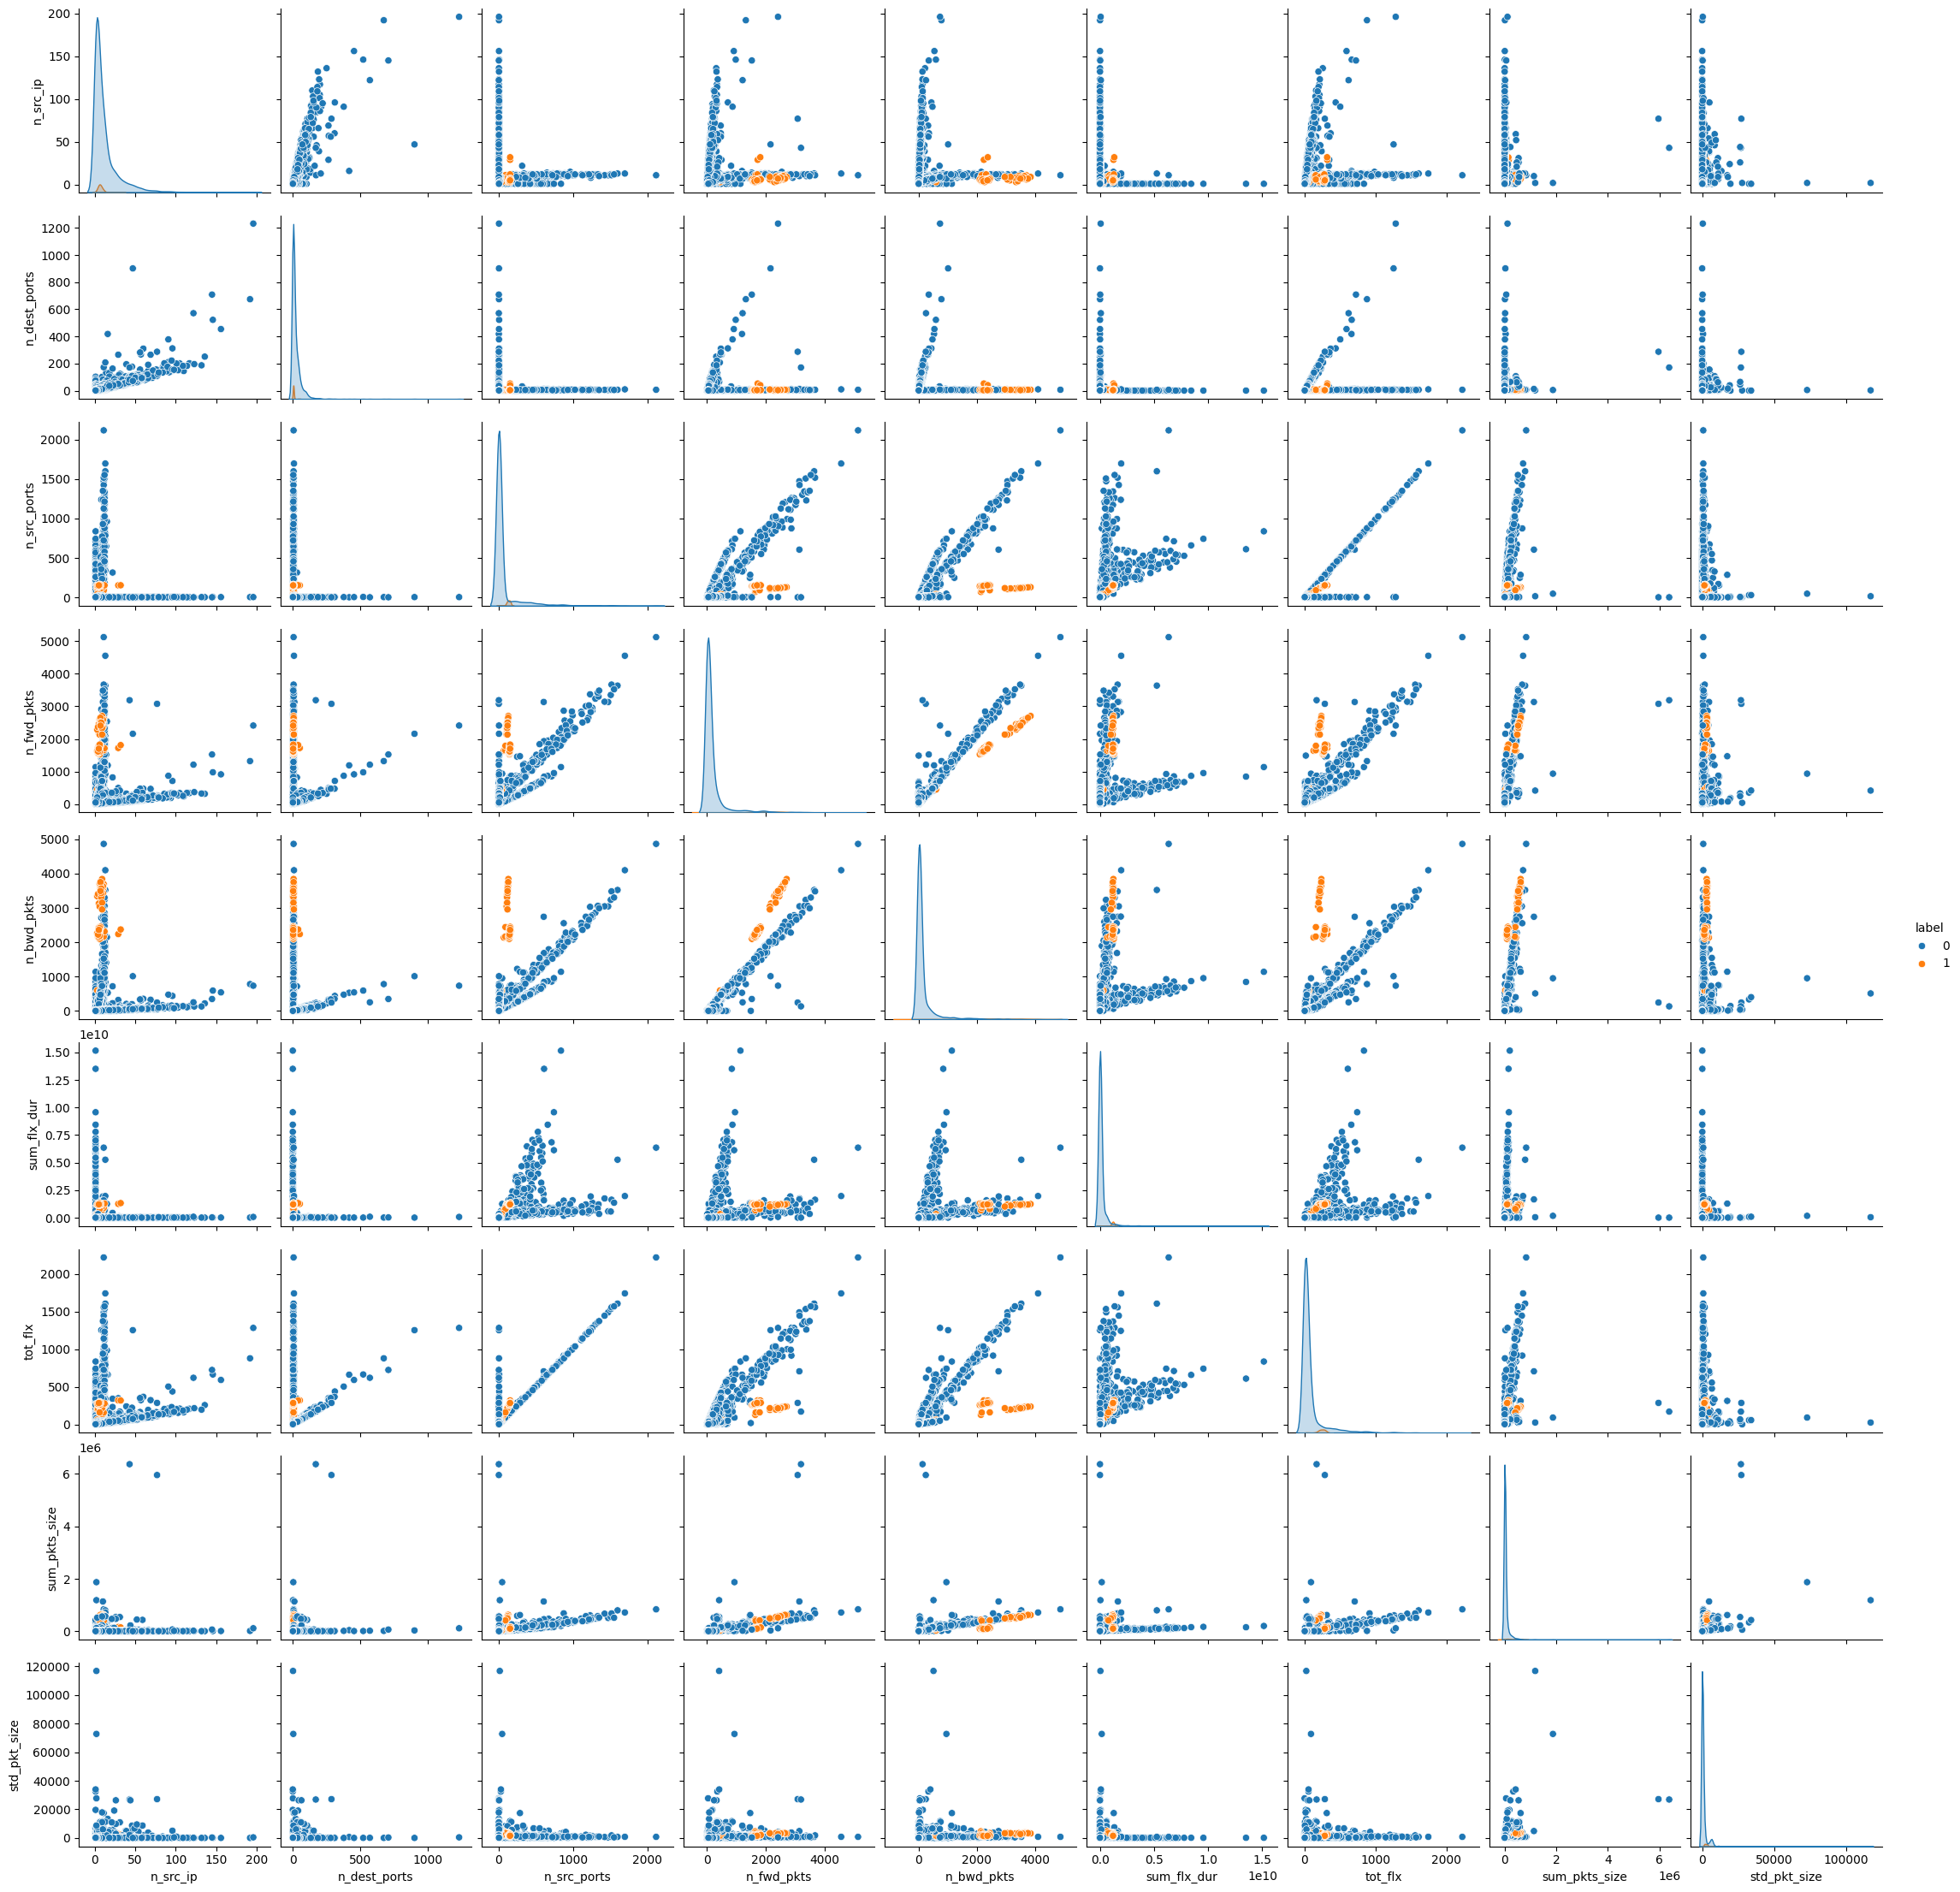

In [10]:
#1.4

sns.pairplot(dfagr, hue='label')

# 1.4.2

On distingue les agrgats d'attaque avec
    - n_bwd_pkts et n_src_port
    - n_bwd_pkts et n_fwd_pkts
    - n_bwd_pkts et tot_flx

Dans ces cas là les attaques sont regroupées à part des communications begnines.
Une IA de classification pourrai réussir à détecter les attaques.

In [11]:
#2.1.1

class Subspace_score:
    X : np.array = None
    X_title : np.array = None
    Y_pred : np.array = None
    y_scores : np.array = None
    y : np.array = None
    agg_field_values = None
    date_end_agg = None
    date_start_agg= None
    y_score_max : int = 0

    def __init__(self) -> None:
        pass


def gen_subspace_score():
    my_data = dfagr.copy()

    # prepare return
    res= Subspace_score()

    # séparate data 
    res.y = my_data['label']
    res.agg_field_values = my_data['agg_field_value']
    res.date_end_agg = my_data['date_end_agg']
    res.date_start_agg = my_data['date_start_agg']
    
    # remove unused column
    my_data.drop(columns=['date_start_agg', 'date_end_agg', 'agg_field_value', 'label'], inplace=True)

    # create combinasions in X_title
    a = itertools.combinations(my_data, 2)
    b = [' '.join(i) for i in a]
    res.y_score_max = len(b)

    # create data
    res.X = np.empty([9, len(my_data['n_src_ip'])])
    res.X_title = np.array(['n_src_ip', 'n_dest_ports', 'n_src_ports', 'n_fwd_pkts', 'n_bwd_pkts', 'sum_flx_dur', 'tot_flx', 'sum_pkts_size', 'std_pkt_size'])

    for i in range(9):
            res.X[i] = my_data[res.X_title[i]]


    res.Y_pred = np.empty([len(b), len(my_data['n_src_ip'])])
    res.y_scores = np.empty(len(my_data['n_src_ip']))


    for i in range(len(b)):
            # create modele
            model = IsolationForest(contamination=0.03)
            
            # train and predict
            index_left = np.where(res.X_title == b[i].split(' ')[0])[0][0]
            index_rigth = np.where(res.X_title == b[i].split(' ')[1])[0][0]
            array = np.array([res.X[index_left], res.X[index_rigth]]).transpose()
            prediction = model.fit_predict(array)

            # transforme prediction in begnin / attaque
            # prediction - 1 ->   (prediction - 1)² -> ((prediction -1 )² )/4
            # 1 -> 0 -> 0 -> 0
            # -1 -> -2 -> 4 -> 1
            
            prediction = (((prediction - 1 ) **2) /4)

            # save prediction
            res.Y_pred[i] = prediction

    res.y_scores = np.sum(res.Y_pred,axis=0)
    
    print("y_score :", res.y_scores)
    print("y_score shape", res.y_scores.shape)

    return res




data_model = gen_subspace_score()


y_score : [0. 0. 0. ... 0. 0. 0.]
y_score shape (3392,)


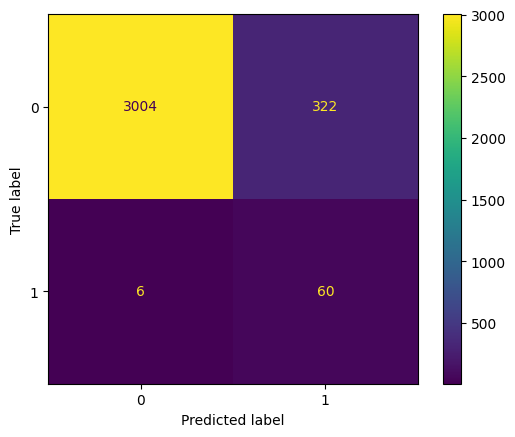

In [12]:
#2.1.2

y_score_apat = np.array([1 if y > 0 else 0 for y in data_model.y_scores])

conf_mat = confusion_matrix(data_model.y, y_score_apat)
disp = ConfusionMatrixDisplay(conf_mat)
disp.plot()

# 2.1.3

Il y a 12 attaques sur 66 qui ne sont pas détectées. 
    Ce qui represente 1/6 des attaques. 
    C'est un resultat pas très satisfaisant.

il y a 322 fausse alerte sur 66 attaques.
    C'est 5 fois plus.
    Ceci generera trop de données à traitées pour levé le doute et les alertes seront prise avec moins de serieux.

Une solution serai de détecté une attaque que si un certain nombre de modèles detectent une attaque.

In [57]:
#3.1

att_folder = "attaque_predict"
benin_folder = "benin_predict"
if not os.path.exists(att_folder):
    os.mkdir(att_folder)

if not os.path.exists(benin_folder):
    os.mkdir(benin_folder)


images = {}
for i in range(len(data_model.agg_field_values)):
    # recup data needed
    begin_date : datetime = data_model.date_start_agg.iloc[i]
    ip_dest = data_model.agg_field_values.iloc[i]
    score_attaque = data_model.y_scores[i]

    # gestion of half hour
    half_hour = 0
    if begin_date.minute >= 30:
        half_hour = 30
    time_floor = begin_date + timedelta(minutes=half_hour - begin_date.minute)
    
    # create image if not exist
    if time_floor not in images:
        images[time_floor] = {"bool attaque" : False}
    
    # create line if not exist
    if ip_dest not in images[time_floor]:
        images[time_floor][ip_dest] = [0] * 15
    
    # find col of pixel
    pixel_column = (begin_date.minute - half_hour ) // 2
    
    # find value of pixel
    pixel_value = int((score_attaque / data_model.y_score_max ) * 255)

    # cet pixel in image
    images[time_floor][ip_dest][pixel_column] = pixel_value

    # define if the image in benin or attacked
    if pixel_value != 0:
         images[time_floor]['bool attaque'] = True
    

for date_image in images:
    nb_line = len(images[date_image])
    image = Image.new('L', (15, nb_line))

    i=0
    for ip_dest in images[date_image]: 
        if ip_dest != "bool attaque":
            for j in range(15):
                image.putpixel((j,i), images[date_image][ip_dest][j])
        i+=1
    name = benin_folder
    if images[date_image]["bool attaque"]:
        name = att_folder
    name = name + "/predict-" + date_image.strftime("%Y-%m-%d-%H-%M")+".png"
    image.save(name)
    print(name, "saved")


attaque_predict/predict-2017-04-07-02-00.png saved
attaque_predict/predict-2017-04-07-02-30.png saved
attaque_predict/predict-2017-04-07-03-00.png saved
attaque_predict/predict-2017-04-07-03-30.png saved
attaque_predict/predict-2017-04-07-09-00.png saved
attaque_predict/predict-2017-04-07-09-30.png saved
attaque_predict/predict-2017-04-07-10-00.png saved
attaque_predict/predict-2017-04-07-10-30.png saved
attaque_predict/predict-2017-04-07-01-00.png saved
attaque_predict/predict-2017-04-07-01-30.png saved
attaque_predict/predict-2017-04-07-04-00.png saved
attaque_predict/predict-2017-04-07-04-30.png saved
benin_predict/predict-2017-04-07-05-00.png saved
attaque_predict/predict-2017-04-07-08-30.png saved
attaque_predict/predict-2017-04-07-11-00.png saved
attaque_predict/predict-2017-04-07-11-30.png saved
attaque_predict/predict-2017-04-07-12-00.png saved
attaque_predict/predict-2017-04-07-12-30.png saved


In [ ]:
#3.2

att_folder = "attaque_reel"
benin_folder = "benin_reel"
if not os.path.exists(att_folder):
    os.mkdir(att_folder)

if not os.path.exists(benin_folder):
    os.mkdir(benin_folder)


images = {}
for i in range(len(data_model.agg_field_values)):
    # recup data needed
    begin_date : datetime = data_model.date_start_agg.iloc[i]
    ip_dest = data_model.agg_field_values.iloc[i]
    score_attaque = data_model.y.iloc[i]

    # gestion of half hour
    half_hour = 0
    if begin_date.minute >= 30:
        half_hour = 30
    time_floor = begin_date + timedelta(minutes=half_hour - begin_date.minute)
    
    # create image if not exist
    if time_floor not in images:
        images[time_floor] = {"bool attaque" : False}
    
    # create line if not exist
    if ip_dest not in images[time_floor]:
        images[time_floor][ip_dest] = [-1] * 15
    
    # find col of pixel
    pixel_column = (begin_date.minute - half_hour ) // 2
    
    # find value of pixel
    pixel_value = score_attaque

    # cet pixel in image
    images[time_floor][ip_dest][pixel_column] = pixel_value

    # define if the image in benin or attacked
    if pixel_value != 0:
         images[time_floor]['bool attaque'] = True
    

for date_image in images:
    nb_line = len(images[date_image])
    image = Image.new('RGB', (15, nb_line))

    i=0
    for ip_dest in images[date_image]: 
        if ip_dest != "bool attaque":
            for j in range(15):
                val = (0,0,0)
                if images[date_image][ip_dest][j] == 0:
                    val = (0,255,0)
                elif images[date_image][ip_dest][j] == 1:
                    val= (255,0,0)
                image.putpixel((j,i), val)
        i+=1
    name = benin_folder
    if images[date_image]["bool attaque"]:
        name = att_folder
    name = name + "/reel-" + date_image.strftime("%Y-%m-%d-%H-%M")+".png"
    image.save(name)
    print(name, "saved")


/tmp/ipykernel_15573/4270607018.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  score_attaque = data_model.y[i]


attaque_reel/reel-2017-04-07-02-00.png saved
attaque_reel/reel-2017-04-07-02-30.png saved
attaque_reel/reel-2017-04-07-03-00.png saved
benin_reel/reel-2017-04-07-03-30.png saved
attaque_reel/reel-2017-04-07-09-00.png saved
attaque_reel/reel-2017-04-07-09-30.png saved
attaque_reel/reel-2017-04-07-10-00.png saved
attaque_reel/reel-2017-04-07-10-30.png saved
benin_reel/reel-2017-04-07-01-00.png saved
benin_reel/reel-2017-04-07-01-30.png saved
benin_reel/reel-2017-04-07-04-00.png saved
benin_reel/reel-2017-04-07-04-30.png saved
benin_reel/reel-2017-04-07-05-00.png saved
benin_reel/reel-2017-04-07-08-30.png saved
benin_reel/reel-2017-04-07-11-00.png saved
benin_reel/reel-2017-04-07-11-30.png saved
benin_reel/reel-2017-04-07-12-00.png saved
benin_reel/reel-2017-04-07-12-30.png saved


In [60]:
with Image.open("attaque_reel/reel-2017-04-07-02-00.png") as im:
    im.show()

with Image.open("attaque_predict/predict-2017-04-07-02-00.png") as im:
    im.show()

# 3.3

La plupart annomalies corespondant à des attaques sont repèrées.  
Les scores d'anomalies sont généralement élevé surtout sur les vraies attaques.  
Ces observations font sens si on regarde sur la duréé:
    - si on détecte une attasue sur une periode (ligne blanche) il est plus probable que se soit une attaque que des pointillés.